In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, ConductanceOptions, FilterParameters, OptimizationParameters
from act.data_processing import get_summary_features, combine_data

In [3]:
# Define the cell
cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "../../data/LAA/orig/target_template.hoc",
    path_to_mod_files = "../../data/LAA/orig/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gmbar_im", "gkabar_kap", "gcabar_cadyn"],
)

# Nap, KM
target_g = np.array([0.0003, 0.002])

In [4]:
grid_values = np.linspace(target_g - 0.5 * target_g, target_g + 0.5 * target_g, num = 40)

In [5]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

index_counter = 0
for g_nap_value in grid_values[:, 0]:
    for g_km_value in grid_values[:, 1]:
            cell = ACTCellModel(
            cell_name = "Cell_A",
            path_to_hoc_file = "../../data/LAA/orig/target_template.hoc",
            path_to_mod_files = "../../data/LAA/orig/modfiles/",
            passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
            active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gmbar_im", "gkabar_kap", "gcabar_cadyn"],
            )
            
            cell.set_g_bar(["gbar_nap", "gmbar_im"], [g_nap_value, g_km_value])

            sim_params = SimulationParameters(
                sim_name = "cell",
                sim_idx = index_counter,
                h_celsius = 37,
                h_dt = 0.1,
                h_tstop = 1000,
                CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100)])
            index_counter += 1
            
            simulator.submit_job(cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [6]:
simulator.run_jobs(5)

In [7]:
# Combine simulated traces into one dataset for convenience
combine_data("output/cell")

output/cell/combined_out.npy


In [8]:
data = np.load("output/cell/combined_out.npy")
V = data[:, :, 0][:, ::10]
I = data[:, :, 1][:, ::10]
g = data[:, :2, 2]

In [9]:
estimated_sf = get_summary_features(V, I, window = (100, 800))

In [10]:
simulator = ACTSimulator(output_folder_name = "output")

cell = ACTCellModel(
        cell_name = "Cell_A",
        path_to_hoc_file = "../../data/LAA/orig/target_template.hoc",
        path_to_mod_files = "../../data/LAA/orig/modfiles/",
        passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
        active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gmbar_im", "gkabar_kap", "gcabar_cadyn"],
        )

sim_params = SimulationParameters(
sim_name = "cell",
sim_idx = 9999,
h_celsius = 37,
h_dt = 0.1,
h_tstop = 1000,
CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100)])

simulator.submit_job(cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [11]:
data = np.load("output/cell/out_9999.npy")
V = data[::10, 0].reshape((1, -1))
I = data[::10, 1].reshape((1, -1))
target_sf = get_summary_features(V, I, window = (100, 800))

In [12]:
target_sf

,mean_v,std_v,max_ampl_v,n_spikes,spike_frequency,spike_0,spike_1,spike_2,spike_3,spike_4,...,isi_12,isi_13,isi_14,isi_15,isi_16,isi_17,isi_18,main_freq,mean_i,std_i
0,-59.479611,9.152827,104.349618,3,4.285714,110.0,165.0,227.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.714286,0.5,0.0


In [13]:
# Z-transform the features
pred = estimated_sf.to_numpy()
z_mean = np.nanmean(pred, axis = 0)
z_std = np.nanstd(pred, axis = 0)

z_std[z_std < 1e-10] = 1

pred = (pred - z_mean) / z_std
pred[np.abs(pred) < 1e-10] = 0

# Use sample mean and std for target transformation
targ = target_sf.to_numpy() 
targ = (targ - z_mean) / z_std

mae = np.nanmean(np.abs(targ - pred), axis = 1)

/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_83767/2791067539.py:3: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(pred, axis = 0)
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


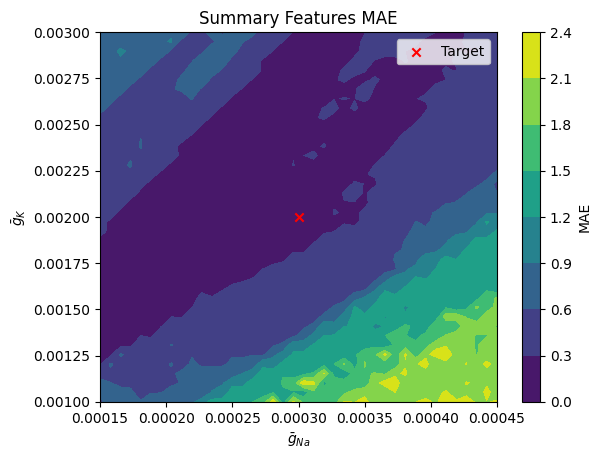

In [14]:
X, Y = np.meshgrid(grid_values[:, 0], grid_values[:, 1], indexing = 'ij')

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, mae.reshape((grid_values.shape[0], grid_values.shape[0])), cmap = 'viridis')
ax.scatter(target_g[0], target_g[1], marker = "x", color = 'red', label = "Target")

ax.set_xlabel(r"$\bar{g}_{Na}$")
ax.set_ylabel(r"$\bar{g}_{K}$")
ax.set_title('Summary Features MAE')
ax.legend()

cbar = fig.colorbar(contour)
cbar.set_label('MAE')

In [20]:
case1 = [None, None]
case2 = [None, None]
case3 = [None, None]
case4 = [0.00026593176732231795, 0.0019735918921820563]

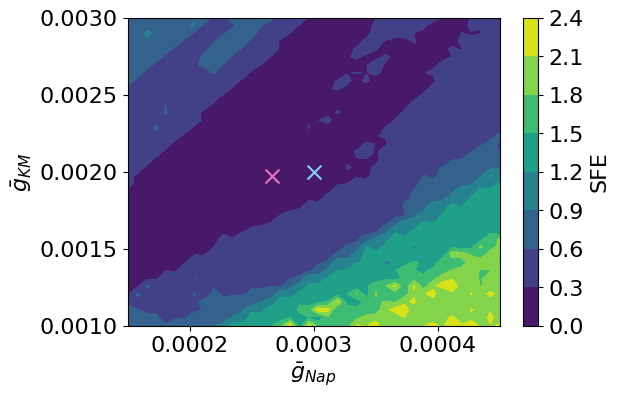

In [24]:
plt.rcParams.update({"font.size": 16})

X, Y = np.meshgrid(grid_values[:, 0], grid_values[:, 1], indexing = 'ij')

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
contour = ax.contourf(X, Y, mae.reshape((grid_values.shape[0], grid_values.shape[0])), cmap = 'viridis')
ax.scatter(target_g[0], target_g[1], marker = "x", s = 100, color = 'lightskyblue', label = "Target")

for case, case_color in zip([case1, case2, case3, case4], ["tab:red", "tab:orange", "tab:green", "tab:pink"]):
    ax.scatter(case[0], case[1], marker = "x", s = 100, color = case_color)

ax.set_xlabel(r"$\bar{g}_{Nap}$")
ax.set_ylabel(r"$\bar{g}_{KM}$")
# ax.set_title('SFE')
# ax.legend()

cbar = fig.colorbar(contour)
cbar.set_label('SFE')

In [25]:
fig.savefig("LAA_error.png", format = 'png', bbox_inches = "tight", dpi = 500)

In [2]:
from act.module import ACTModule

In [ ]:
cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

target_g = np.array([0.0003, 0.12, 0.036])

sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = 0, high = 1, n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = 0, high = 1, n_slices = 3),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.7, dur = 700, delay = 100)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

In [4]:
m = ACTModule(
    name = "orig",
    cell = cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [5]:
m.run()

Running Module 'orig'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/train/combined_out.npy
Training RandomForest...
Predicting on target data...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/eval/combined_out.npy
Evaluating predictions...
Predicting on target data...
{'hh_spiker.gnabar': 0.7075, 'hh_spiker.gkbar': 0.4455}
Done.


/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:30: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:32: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:35: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:35: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


,metric,value
0,Train MAE (g),1.728241e-01
1,Test SFE (g0),1.621296e+16
2,Test SFE (g1),2.738189e+16
3,Test SFE (g2),1.717603e+01
4,Test MAE (FI),4.033333e+00
5,Runtime (s),1.151400e+01


In [6]:
m.cell.prediction

{'hh_spiker.gnabar': 0.7075, 'hh_spiker.gkbar': 0.4455}

In [7]:
optim_params2 = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = 0, high = 1, n_slices = 3, bounds_variation = 0.2),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
        ConstantCurrentInjection(amp = 0.7, dur = 700, delay = 100, lto_hto = 0)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

m2 = ACTModule(
    name = "orig2",
    cell = cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params2,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [8]:
m2.run()

Running Module 'orig2'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig2/train/combined_out.npy
Training RandomForest...
Predicting on target data...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig2/eval/combined_out.npy
Evaluating predictions...
Predicting on target data...
{'hh_spiker.gnabar': 0.6609327000000043}
Done.


/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:32: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:35: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std


,metric,value
0,Train MAE (g),0.005852
1,Test SFE (g0),268.633932
2,Test SFE (g1),929.489153
3,Test SFE (g2),1491.443222
4,Test MAE (FI),5.000000
5,Runtime (s),10.832000
